In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer,  make_column_selector as selector
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import plot_confusion_matrix, recall_score,\
    accuracy_score, precision_score, f1_score
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImPipeline
from sklearn.tree import DecisionTreeClassifier

# Business Problem: 


#### Associated Costs

- False Positives: overtargeting customers with promotions will result primarily in opportunity cost in that those promotions did not need to be offered in order to retain customers. 
- False Negatives: failing to identify customers who are truly at risk for churn is more costly to the company as having too high of a customer churn rate could impact the company's ability to stay in business. 

Since the majority of customers are not at great risk to churn (Roughly 85%), simply targetting all customers for promotional deals is not viable as it will result in the company taking on huge opportunity cost.\

The best model for this problem will yield the highest Accuracy and Recall scores. High Accuracy will allow for the stakeholder to appropriate funding for methods for customer retention such as promotions and discounts to only customers likely to churn, and balancing that with a high Recall score will ensure that the majority of customers who will churn can be identified for the aforementioned methods. 

# Exploratory Data Analysis and Data Preparation

In [2]:
# initialize dataframe
telecom_df = pd.read_csv('telecom.csv')

__Columns to Drop:__
- 'area code': There are only 3 area codes across all of the states. This appears to be either incorrect data or at the least not meaningful in the context of predicting customer churn.
- 'phone number': Each number will be unique and could only be used as an ID. Since there is already an 'id', we no longer need to keep phone number

In [3]:
# drop code
telecom_df = telecom_df.drop(['area code', 'phone number'], axis=1)

In [4]:
telecom_df.columns

Index(['state', 'account length', 'international plan', 'voice mail plan',
       'number vmail messages', 'total day minutes', 'total day calls',
       'total day charge', 'total eve minutes', 'total eve calls',
       'total eve charge', 'total night minutes', 'total night calls',
       'total night charge', 'total intl minutes', 'total intl calls',
       'total intl charge', 'customer service calls', 'churn'],
      dtype='object')

In [5]:
telecom_df['churn'].value_counts()

False    2850
True      483
Name: churn, dtype: int64

__Variables:__
- Target: 'churn'
- Independent Variables: Others

In [6]:
# initialize variables
X = telecom_df.drop('churn', axis=1)
y = telecom_df['churn']

# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

### Pipelines
Goal: Set up processes to handle both numerical and categorical variables for use in downstream modeling pipelines

In [7]:
# setup pipelines
subpipe_num = Pipeline(steps=[
    ('num_impute', SimpleImputer(strategy='median')),
    ('ss', StandardScaler())
])

subpipe_cat = Pipeline(steps=[
    ('cat_impute', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'))
])

In [8]:
# setup column transformer to handle numerical/categorical vars
column_transformer = ColumnTransformer(transformers=[
    ('subpipe_num', subpipe_num, selector(dtype_include=np.number)),
    ('subpipe_cat', subpipe_cat, selector(dtype_include=object))], remainder='passthrough')

Any pipelines downstream that reference column_transformer will be imputed, scaled, and ohe'd if categorical

# Predictive Modeling

__ModelWithCV Class:__

In [9]:
class ModelWithCV():
    '''Structure to save the model and more easily see its crossvalidation'''
    
    def __init__(self, model, model_name, X, y, cv_now=True):
        self.model = model
        self.name = model_name
        self.X = X
        self.y = y
        # For CV results
        self.cv_results = None
        self.cv_mean = None
        self.cv_median = None
        self.cv_std = None
        #
        if cv_now:
            self.cross_validate()
        
    def cross_validate(self, X=None, y=None, kfolds=10):
        '''
        Perform cross-validation and return results.
        
        Args: 
          X:
            Optional; Training data to perform CV on. Otherwise use X from object
          y:
            Optional; Training data to perform CV on. Otherwise use y from object
          kfolds:
            Optional; Number of folds for CV (default is 10)  
        '''
        
        cv_X = X if X else self.X
        cv_y = y if y else self.y

        self.cv_results = cross_val_score(self.model, cv_X, cv_y, cv=kfolds)
        self.cv_mean = np.mean(self.cv_results)
        self.cv_median = np.median(self.cv_results)
        self.cv_std = np.std(self.cv_results)

        
    def print_cv_summary(self):
        cv_summary = (
        f'''CV Results for `{self.name}` model:
            {self.cv_mean:.5f} ± {self.cv_std:.5f} accuracy
        ''')
        print(cv_summary)

        
    def plot_cv(self, ax):
        '''
        Plot the cross-validation values using the array of results and given 
        Axis for plotting.
        '''
        ax.set_title(f'CV Results for `{self.name}` Model')
        # Thinner violinplot with higher bw
        sns.violinplot(y=self.cv_results, ax=ax, bw=.4)
        sns.swarmplot(
                y=self.cv_results,
                color='orange',
                size=10,
                alpha= 0.8,
                ax=ax
        )

        return ax

#### Baseline

In [10]:
# model
dummy_model_pipe = Pipeline(steps=[
    ('ct', column_transformer),
    ('dum', DummyClassifier(strategy='most_frequent'))
])

In [11]:
# model
dummy_pipe = ModelWithCV(dummy_model_pipe, 'dummy_model', X_train, y_train)

<AxesSubplot:title={'center':'CV Results for `dummy_model` Model'}>

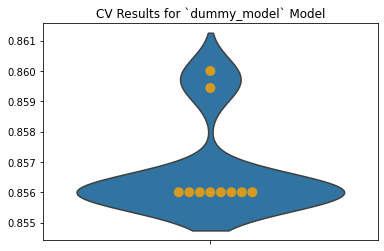

In [12]:
# plot
fig, ax = plt.subplots()

dummy_pipe.plot_cv(ax)

In [13]:
# results
dummy_pipe.print_cv_summary()

CV Results for `dummy_model` model:
            0.85674 ± 0.00149 accuracy
        


__First Simple Model - Logistic Regression__

In [14]:
# model
logreg_model_pipe = Pipeline([
    ('ct', column_transformer),
    ('logreg', LogisticRegression(random_state=42))
])

In [15]:
# model
logreg_pipe = ModelWithCV(logreg_model_pipe, 'logreg_model', X_train, y_train)

<AxesSubplot:title={'center':'CV Results for `logreg_model` Model'}>

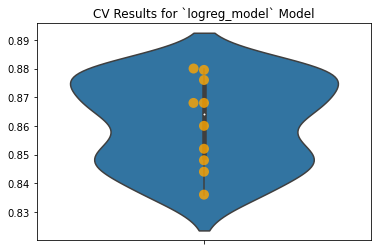

In [16]:
# plot
fig, ax = plt.subplots()

logreg_pipe.plot_cv(ax)

In [17]:
# results
logreg_pipe.print_cv_summary()

CV Results for `logreg_model` model:
            0.86115 ± 0.01480 accuracy
        


#### Decision Tree Model

In [18]:
# model
dtree_model_pipe = Pipeline([('ct', column_transformer),
                             ('dtree', DecisionTreeClassifier(random_state=42))])

In [19]:
# model
rfc_pipe = ModelWithCV(dtree_model_pipe, 'dtree_model', X_train, y_train)

<AxesSubplot:title={'center':'CV Results for `dtree_model` Model'}>

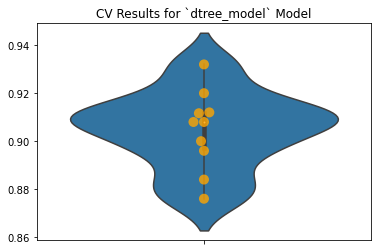

In [20]:
# plot
fig, ax = plt.subplots()

rfc_pipe.plot_cv(ax)

In [21]:
# results
rfc_pipe.print_cv_summary()

CV Results for `dtree_model` model:
            0.90476 ± 0.01566 accuracy
        


#### K-Nearest Neighbors Model

In [22]:
# model
knn_model_pipe = Pipeline([
    ('ct', column_transformer),
    ('knn', KNeighborsClassifier())
])

In [23]:
knn_pipe = ModelWithCV(knn_model_pipe, 'knn_model', X_train, y_train)

<AxesSubplot:title={'center':'CV Results for `knn_model` Model'}>

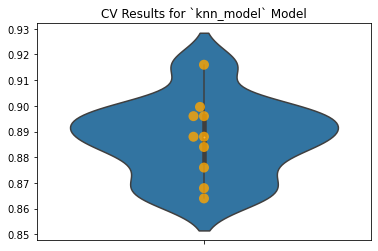

In [24]:
# plot
fig, ax = plt.subplots()

knn_pipe.plot_cv(ax)

In [25]:
# results
knn_pipe.print_cv_summary()

CV Results for `knn_model` model:
            0.88756 ± 0.01477 accuracy
        


#### Random Forest Model

In [26]:
# model
rfc_model_pipe = Pipeline([('ct', column_transformer),
                           ('rfc', RandomForestClassifier(random_state=42))])

In [27]:
# model
rfc_pipe = ModelWithCV(rfc_model_pipe, 'rfc_model', X_train, y_train)

<AxesSubplot:title={'center':'CV Results for `rfc_model` Model'}>

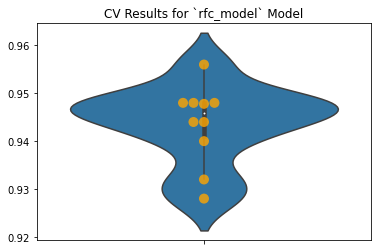

In [28]:
# plot
fig, ax = plt.subplots()

rfc_pipe.plot_cv(ax)

In [29]:
# results
rfc_pipe.print_cv_summary()

CV Results for `rfc_model` model:
            0.94358 ± 0.00788 accuracy
        


#### Gradient Boosting Model

In [30]:
# model
gbc_model_pipe = Pipeline([
    ('ct', column_transformer),
    ('gbc', GradientBoostingClassifier(random_state=42))
])

In [31]:
# model
gbc_pipe = ModelWithCV(gbc_model_pipe, 'gbc_model', X_train, y_train)

<AxesSubplot:title={'center':'CV Results for `gbc_model` Model'}>

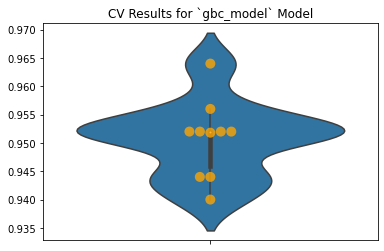

In [32]:
# plot
fig, ax = plt.subplots()

gbc_pipe.plot_cv(ax)

In [33]:
# results
gbc_pipe.print_cv_summary()

CV Results for `gbc_model` model:
            0.95078 ± 0.00646 accuracy
        


## Model Cross Validation and Hyperparameter Tuning

#### DecisionTree 

In [89]:
# pipeline
imb_pipe_dtree = ImPipeline(steps=[
    ('ct', column_transformer),
    ('sm', SMOTE(random_state=42)),
    ('dtree', DecisionTreeClassifier())
])

In [90]:
# fit training data
imb_pipe_dtree.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('subpipe_num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001B651348370>),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                       

In [91]:
# initial score
imb_pipe_dtree.score(X_train, y_train)

1.0

In [105]:
# DTree Parameters
parameters_dtree = {
    'dtree__max_depth': [2,4,6,8,10],
    'dtree__criterion': ['gini', 'entropy'],
    'dtree__min_samples_leaf': [1, 5, 10, 25, 50]
}

gs_dtree = GridSearchCV(imb_pipe_dtree, parameters_dtree)

In [106]:
# refit training data
gs_dtree.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('subpipe_num',
                                                                         Pipeline(steps=[('num_impute',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('ss',
                                                                                          StandardScaler())]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x000001B651348370>),
                                                                        ('subpipe_cat',
                                                                         Pipeline(steps=[('cat_i

In [107]:
# view best parameters from grid search
gs_dtree.best_params_

{'dtree__criterion': 'gini',
 'dtree__max_depth': 10,
 'dtree__min_samples_leaf': 5}

In [108]:
# initialize model w/ optimal hyperparameters
dtree_model_best = ImPipeline(steps=[
    ('ct', column_transformer),
    ('sm', SMOTE(random_state=42)),
    ('dtree', DecisionTreeClassifier(criterion='gini', max_depth=10, min_samples_leaf=5))
])

In [109]:
# refit training data
dtree_model_best.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('subpipe_num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001B651348370>),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                       

In [110]:
# rescore
dtree_model_best.score(X_train, y_train)

0.9631852741096438

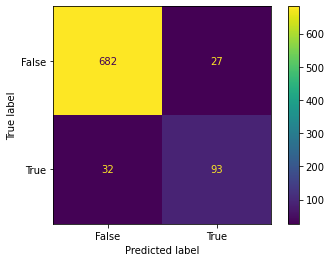

In [112]:
# confusion matrix
plot_confusion_matrix(dtree_model_best, X_test, y_test);

In [113]:
# predictions
dtree_y_hat = dtree_model_best.predict(X_test)

In [114]:
# summry
print(f"""
Our DecisionTree model's accuracy on the test set is {round(accuracy_score(y_test, dtree_y_hat), 2)}. \n
Our DecisionTree model's recall on the test set is {round(recall_score(y_test, dtree_y_hat), 2)} \n
Our DecisionTree model's precision on the test set is {round(precision_score(y_test, dtree_y_hat), 2)} \n
Our DecisionTree model's f1-score on the test is {round(f1_score(y_test, dtree_y_hat), 2)}.
""")


Our DecisionTree model's accuracy on the test set is 0.93. 

Our DecisionTree model's recall on the test set is 0.74 

Our DecisionTree model's precision on the test set is 0.78 

Our DecisionTree model's f1-score on the test is 0.76.



#### KNearestNeighbors

In [34]:
# pipeline
imb_pipe_knn = ImPipeline(steps=[
    ('ct', column_transformer),
    ('sm', SMOTE(random_state=42)),
    ('knn', KNeighborsClassifier())
])

In [35]:
# fit training data
imb_pipe_knn.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('subpipe_num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001B651348370>),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                       

In [36]:
# initial score
imb_pipe_knn.score(X_train, y_train)

0.8651460584233693

In [37]:
# KNN Parameters
parameters_knn = {
    'knn__p': [1,2],
    'knn__leaf_size': [15, 30, 45]
}

gs_knn = GridSearchCV(imb_pipe_knn, parameters_knn)

In [38]:
# refit
gs_knn.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('subpipe_num',
                                                                         Pipeline(steps=[('num_impute',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('ss',
                                                                                          StandardScaler())]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x000001B651348370>),
                                                                        ('subpipe_cat',
                                                                         Pipeline(steps=[('cat_i

In [39]:
# view best hyperparameters
gs_knn.best_params_

{'knn__leaf_size': 15, 'knn__p': 1}

In [40]:
# initialize knn model w/ optimal hyperparameters
knn_model_best = ImPipeline(steps=[
    ('ct', column_transformer),
    ('sm', SMOTE(k_neighbors=5, random_state=42)),
    ('knn', KNeighborsClassifier(leaf_size=15, p=1))
])

In [41]:
# refit
knn_model_best.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('subpipe_num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001B651348370>),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                       

In [42]:
# rescore
knn_model_best.score(X_train, y_train)

0.9087635054021609

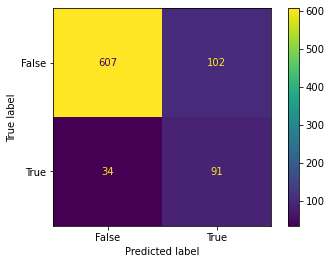

In [43]:
# confusion matrix
plot_confusion_matrix(knn_model_best, X_test, y_test);

In [44]:
# knn predicts
knn_y_hat = knn_model_best.predict(X_test)

In [45]:
# knn summary
print(f"""
Our KNearestNeighbor model's accuracy on the test set is {round(accuracy_score(y_test, knn_y_hat), 2)}. \n
Our KNearestNeighbor model's recall on the test set is {round(recall_score(y_test, knn_y_hat), 2)} \n
Our KNearestNeighbor model's precision on the test set is {round(precision_score(y_test, knn_y_hat), 2)} \n
Our KNearestNeighbor model's f1-score on the test is {round(f1_score(y_test, knn_y_hat), 2)}.
""")


Our KNearestNeighbor model's accuracy on the test set is 0.84. 

Our KNearestNeighbor model's recall on the test set is 0.73 

Our KNearestNeighbor model's precision on the test set is 0.47 

Our KNearestNeighbor model's f1-score on the test is 0.57.



### RandomForestClassifier

In [46]:
# pipeline
imb_pipe_rfc = ImPipeline(steps=[
    ('ct', column_transformer),
    ('sm', SMOTE()),
    ('rfc', RandomForestClassifier())
])

In [47]:
# fit training data
imb_pipe_rfc.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('subpipe_num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001B651348370>),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                       

In [48]:
# initial score
imb_pipe_rfc.score(X_train, y_train)

1.0

In [49]:
# randomforest params
parameters_rfc = {
    'rfc__criterion': ['gini', 'entropy'],
    'rfc__min_samples_leaf': [1,5,10],
}

gs_rfc = GridSearchCV(imb_pipe_rfc, parameters_rfc)

In [50]:
# fit to gridsearch
gs_rfc.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('subpipe_num',
                                                                         Pipeline(steps=[('num_impute',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('ss',
                                                                                          StandardScaler())]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x000001B651348370>),
                                                                        ('subpipe_cat',
                                                                         Pipeline(steps=[('cat_i

In [51]:
# view best parameters
gs_rfc.best_params_

{'rfc__criterion': 'entropy', 'rfc__min_samples_leaf': 1}

In [52]:
# rescore
gs_rfc.best_score_

0.9415791583166333

In [53]:
# initialize randomforest w/ optimal hyperparameters
rfc_model_best = ImPipeline(steps=[
    ('ct', column_transformer),
    ('sm', SMOTE(k_neighbors=5, random_state=42)),
    ('rfc', RandomForestClassifier(criterion='gini',  min_samples_leaf=1))
])

In [54]:
# fit 
rfc_model_best.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('subpipe_num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001B651348370>),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                       

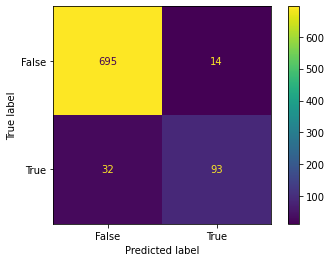

In [124]:
# confusion matrix
plot_confusion_matrix(rfc_model_best, X_test, y_test);

In [56]:
# randomforest predics
rfc_y_hat = rfc_model_best.predict(X_test)

In [57]:
# summary
print(f"""
Our RandomForest model's accuracy on the test set is {round(accuracy_score(y_test, rfc_y_hat), 2)}. \n
Our RandomForest model's recall on the test set is {round(recall_score(y_test, rfc_y_hat), 2)} \n
Our RandomForest model's precision on the test set is {round(precision_score(y_test, rfc_y_hat), 2)} \n
Our RandomForest model's f1-score on the test is {round(f1_score(y_test, rfc_y_hat), 2)}.
""")


Our RandomForest model's accuracy on the test set is 0.94. 

Our RandomForest model's recall on the test set is 0.74 

Our RandomForest model's precision on the test set is 0.87 

Our RandomForest model's f1-score on the test is 0.8.



### GradientBoosting

In [58]:
# pipeline
imb_pipe_gbc = ImPipeline(steps=[
    ('ct', column_transformer),
    ('sm', SMOTE(random_state=42)),
    ('gbc', GradientBoostingClassifier(random_state=42))
])

In [59]:
# fit
imb_pipe_gbc.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('subpipe_num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001B651348370>),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                       

In [60]:
# initial score
imb_pipe_gbc.score(X_train, y_train)

0.957983193277311

In [115]:
# gradientboosting params
parameters_gbc = {
    'gbc__learning_rate': [0.1, 0.3, 0.5, 0.7],
    'gbc__min_samples_leaf': [1,5,10,25],
}

gs_gbc = GridSearchCV(imb_pipe_gbc, parameters_gbc)

In [116]:
# fit
gs_gbc.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('subpipe_num',
                                                                         Pipeline(steps=[('num_impute',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('ss',
                                                                                          StandardScaler())]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x000001B651348370>),
                                                                        ('subpipe_cat',
                                                                         Pipeline(steps=[('cat_i

In [117]:
# best params
gs_gbc.best_params_

{'gbc__learning_rate': 0.5, 'gbc__min_samples_leaf': 10}

In [119]:
# model w/ best params
gbc_model_best = ImPipeline(steps=[
    ('ct', column_transformer),
    ('sm', SMOTE(k_neighbors=5, random_state=42)),
    ('gbc', GradientBoostingClassifier(learning_rate=0.5,  min_samples_leaf=10))
])

In [120]:
# fit
gbc_model_best.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('subpipe_num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001B651348370>),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                       

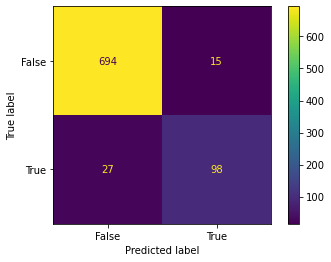

In [121]:
# confusion matrix
plot_confusion_matrix(gbc_model_best, X_test, y_test);

In [122]:
# gradientboosting predicts
y_hat_gbc = gbc_model_best.predict(X_test)

In [123]:
# score summary
print(f"""
Our GradientBoosting model's accuracy on the test set is {round(accuracy_score(y_test, y_hat_gbc), 2)}. \n
Our GradientBoosting model's recall on the test set is {round(recall_score(y_test, y_hat_gbc), 2)} \n
Our GradientBoosting model's precision on the test set is {round(precision_score(y_test, y_hat_gbc), 2)} \n
Our GradientBoosting model's f1-score on the test is {round(f1_score(y_test, y_hat_gbc), 2)}.
""")


Our GradientBoosting model's accuracy on the test set is 0.95. 

Our GradientBoosting model's recall on the test set is 0.78 

Our GradientBoosting model's precision on the test set is 0.87 

Our GradientBoosting model's f1-score on the test is 0.82.



__GradientBoosting__ is our best performing model, yielding the highest cross validation scores across the board, specifically with Accuracy and Recall which are the key metrics. for our telecom stakeholder. 

Our model performed best with a slower learning rate (0.5 vs 1 by default), with the risk of overfitting offset by the adjustment to the minimum required samples per leaf (10 vs 1). 

With an accuracy score of 0.95, our model can correctly predict __95%__ of the total population, meaning that our stakeholder will be able to not waste promotional dollars and take on the opportunity cost of giving customers who are unlikely to churn either way discounted rates.

With a recall score of 0.78, our GradientBoosting model is able to accurately predict __78%__ of all churn customers, allowing for more focused targetting of customer retention efforts while not having to take on the opportunity cost of wasted marketing and promotional dollars on customers who are not likely to churn either way.